# Autoregressive models using a feedforward neural network (pytorch implementation)
## PART 2: Applying the methods to health care time series 

In this notebook we will use a feedforward neural network to fit a single and ensemble linear and non-linear models to real time series data. 

<div class="alert alert-info">
    
1. Most of the work we will do is data manipulation: preprocessing data and making sure it is the right shape for the neural networks.

2. The ensemble learning method can be computationally expensive.  We have included some pre-trained models that can be loaded from file if your machine is not powerful or you cannot use Google Collabratory.
</div>

---
**LEARNING OBJECTIVES**

* Learn how to apply feedforward neural networks to real health data.
* Methods to preprocess nn input data.
* Recognise the stochastic nature of neural network training
* Use a ensemble of neural networks to provide a more reliable point forecast
---


## 1. Python dependencies

It is recommended that you use the forecasting course conda environment provided. We are again going to implement neural networks using `tensorflow` and '`keras`. You should be using at least `tensorflow` version `2.1.0`.

In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.tools.eval_measures import rmse

#pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import time

torch.__version__

'1.4.0'

## 2. Forecasting emergency admissions in England

We will now use feedforward neural networks to predict the number of monthly emergency admissions in England. 

### 2.1 Load the data

**Task**:
* Execute the code below to read the emergency admissions data into pandas

In [66]:
url = 'https://raw.githubusercontent.com/health-data-science-OR/data/master/em_admits_ts.csv'
em_admits = pd.read_csv(url)

In [67]:
em_admits.head(3)

,month_year,em_admits
0,Aug-10,425702
1,Sep-10,424900
2,Oct-10,436215


In [68]:
em_admits.shape

(111, 2)

## 2.3. Preprocessing 

### 2.3.1 Datetime format

Notice the the `month_year` column in `em_admits` holds a string an invalid date format e.g. 'Aug-10'.  Pandas cannot handle this as-is because '10' could refer to any century!  So let's do a bit of preprocessing to get it into a valid datetime format.


*Optional Task:*
* Take some time to understand the code that preprocesses the dates.  This is real health data and it is likely you will need to deal with formatting issues as experienced here.

First we will format the string to something pandas can parse i.e. 'Aug 2010'.  Then we will call the `pd.to_datetime()` function to parse the string and return a `datetime`.  We will assign the result to our dataframe's index and set the freq to monthly start 'MS'

In [69]:
date_str = em_admits['month_year'].str[:3] + ' 20' + em_admits['month_year'].str[-2:]
date_str.name = 'date'
em_admits = em_admits.set_index(pd.to_datetime(date_str))
em_admits.index.freq = 'MS'
em_admits = em_admits.drop(columns=['month_year'])

In [70]:
em_admits.head()

,em_admits
date,
2010-08-01,425702
2010-09-01,424900
2010-10-01,436215
2010-11-01,429099
2010-12-01,452728


### 2.3.2 Visualise the training data

We will be forecasting the last 12 months of the series.  Let's take a look at the training data (being careful to exclude the last 12 months)

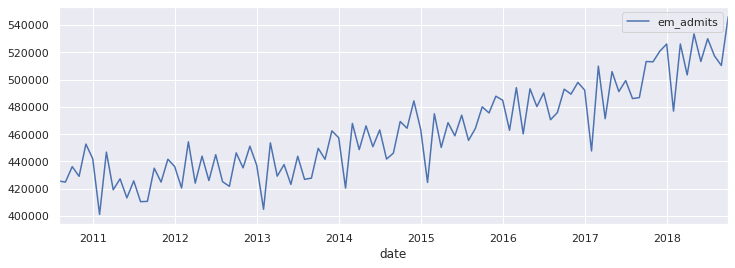

In [71]:
holdout_length = 12
em_admits[:len(em_admits)-holdout_length].plot(figsize=(12,4));

### 2.3.2 Calender adjustment

This is monthly data so a useful preprocessing step is to transform the data into a daily rate by dividing by the number of days in the month. When we plot this the troughs we saw in Feb each year disappear.

**Exercise**:
* Calculate the average admissions per day series
* Plot the training data (holding back 12 months for testing)

In [72]:
admit_rate = em_admits['em_admits'] / em_admits.index.days_in_month

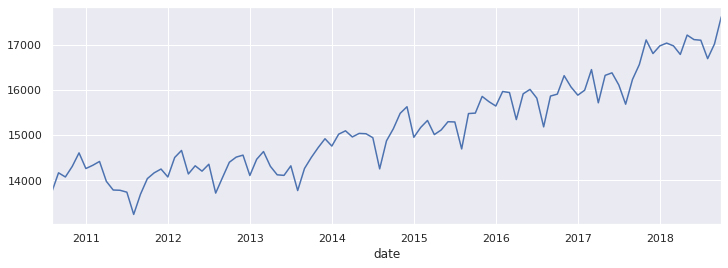

In [9]:
admit_rate[:len(admit_rate)-12].plot(figsize=(12,4));

### 2.3.3 Convert the time series to format suitable for supervised learning.

Exercise:
* Using a sliding window approach convert the time series into a tabular format. 
 * Use a window size of 12 and assume you are predicting a scalar value of y (1-step ahead).
* Conduct a train test split holding back 12 windows for test.

In [73]:
def sliding_window(train, window_size=2, horizon=1):
    '''
    sliding window.
    
    Parameters:
    --------
    train: array-like
        training data for time series method
    
    window_size: int, optional (default=2)
        lookback - how much lagged data to include.
        
    horizon: int, optional (default=1)
        number of observations ahead to predict
            
    Returns:
        array-like, array-like
    
        preprocessed X, preprocessed Y
    '''
    tabular_X = []
    tabular_y = []
    
    for i in range(0, len(train) - window_size - horizon):
        X_train = train[i:window_size+i]
        y_train = train[i+window_size+horizon-1]
        tabular_X.append(X_train)
        tabular_y.append(y_train)
       
    return np.asarray(tabular_X), np.asarray(tabular_y).reshape(-1, )

In [74]:
def to_tensors(*arrays):
    results = ()
    for a in arrays:
        results += torch.FloatTensor(a),
    return results

In [75]:
def get_data_loader(X, y, batch_size=32):
    '''
    Set up train data as a TensorDataSet
    '''
    tensor_data = TensorDataset(torch.FloatTensor(X),
                                torch.FloatTensor(y))

    return DataLoader(tensor_data, 
                      batch_size=batch_size, 
                      shuffle=False)

In [76]:
def ts_train_test_split(*arrays, train_size, as_tensors=True):
    '''
    time series train test split
    
    Parameters:
    X: array-like
        X data
    y_data 
    '''
    results = ()
    for a in arrays:
        if as_tensors:
            results += to_tensors(a[:train_size], a[train_size:])
        else:
            results += a[:train_size], a[train_size:]

    return results

In [77]:
WINDOW_SIZE = 12

#preprocess time series into a supervised learning problem
X_data, y_data = sliding_window(admit_rate, window_size=WINDOW_SIZE)

#train test split
train_size = len(y_data) - 12
X_train, X_test, y_train, y_test = ts_train_test_split(X_data, 
                                                y_data,
                                                train_size=train_size,
                                                as_tensors=True)

### 2.3.4 Scaling the features and target to be between -1 and 1
In many machine learning applications data are scaled to be between 0 and 1. For neural network forecasting, *Ord, Fildes and Kourentzes (2017)* recommend scaling to be between -1 and 1.  This is what we will do here.  To do the scaling we will use

```python
sklearn.preprocessing.MinMaxScaler
```

* Execute the code below to transform the data.

**TO ADD: short video or seperate notebook of how min max scaler works**

In [78]:
from sklearn.preprocessing import MinMaxScaler

In [79]:
scaler = MinMaxScaler(feature_range=(-1, 1))

#I am scaling on admit_rate because this will include the first 12 lags 
#not in y_train
scaler.fit(admit_rate.iloc[:-12].to_numpy().reshape(-1, 1))

MinMaxScaler(feature_range=(-1, 1))

In [80]:
y_train = scaler.transform(y_train.reshape(-1, 1))
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_test = scaler.transform(y_test.reshape(-1, 1))

In [81]:
X_train, y_train, X_test, y_test = to_tensors(X_train, y_train, X_test, y_test)

## 2.4 A Linear regression model benchmark

The first model we will try is the linear model. Its will serve as our neural network baseline.  (In practice we would likely use something more complex as a neural network benchmarch and also check this is better than a naive method such as seasonal naive).

### 2.4.1. Train the model

**Exercise:**
* Using `torch`, construct a neural network that mimics a simple linear regression model (see previous notebook).  
* Optional: To get comparable results, set the torch random number seed to 1234
* Train the model for 100 epochs.
* Optionally you can use an early stopping callback with patience set to 10.

In [159]:
# Base model on torch.nn.Module class
class LinearModel(nn.Module):
    def __init__(self, window_size):
        # Inherit parent (nn.module) methods using super init
        super(LinearModel, self).__init__()
        # Linear model only has a single layer 
        # window_size input containing our lags
        #a Linear object is the same as Keras' Dense layer.
        self.layer1 = nn.Linear(in_features=window_size, 
                                out_features=1, 
                                bias=True)   
        
    def forward(self, x):
        # Pass data through net. 
        y_pred = self.layer1(x)
        return y_pred

In [83]:
def fit(model, optimizer, criterion, n_epochs, 
        X_train, y_train, X_test=None, y_test=None, 
        batch_size=32, verbose=0):
    '''
    train the pytorch model 
    
    Parameters:
    ------
    model: torch.nn.module
        PyTorch Neural Network Model implements .forward()
    
    optimizer: torch.optim.Optimizer
        PyTorch optimization engine e.g. Adam
        
    criterion: torch.nn.criterion
        PyTorch criterion e.g. MSELoss 
        
    n_epochs: int
        Number of epochs to train
        
    X_train: Tensor
        x training matrix 2D
        
    y_train: Tensor
        y training vector
        
    X_test: Tensor, optional (default=None)
        x test matrix 2D
        
    y_test: Tensor, optional (default=None)
        y test vector
        
    batch_size: int, optional (default=32)
        Size of the mini batches used in training
        
    verbose: int, optional (default=0)
        0 == no output during training
        1 == output loss every 10 epochs 
        (includes validation loss if X_test, y_test included)
    
    Returns:
    -------
        dict
        training and validation loss history. keys are
        'loss' and 'val_loss'
    '''
    PRINT_STEPS = 10

    # Set up lists for loss
    train_losses = []
    test_losses = []

    history = {'loss':[],
               'val_loss':[]}

    #create the mini-batches
    train_loader = get_data_loader(X_train, 
                               y_train, 
                               batch_size=batch_size)
    start_time = time.time()
    
    # Loop through required number of epochs
    for epoch in range(n_epochs):
        # Train model (using batches): Switch to training mode
        model.train()
        for batch in train_loader:
            
            y_pred = model.forward(batch[0])
            loss = criterion(y_pred, batch[1].reshape(y_pred.shape[0], -1))

            # Zero gradients, perform a backward pass,  
            # and update the weights. 
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step() 

        # Get results for complete training set: Switch to evaluation mode
        model.eval()
        y_pred_train = model.forward(X_train)
        history['loss'].append(criterion(y_pred_train, 
                                         y_train.reshape(y_pred_train.shape[0], -1)).detach())

        if not X_test is None:
            # Get results for test set
            y_pred_test = model.forward(X_test)
            history['val_loss'].append(criterion(y_pred_test, 
                                                 y_test.reshape(y_pred_test.shape[0], -1)).detach())

        # Print loss & accuracy every 10 epochs (print last iteem of results lists)
        if verbose == 1:
            if (epoch+1) % PRINT_STEPS == 0:
                print(f'Epoch {epoch+1}. ', end='')
                print(f"Train accuracy {history['loss'][-1]: 0.3f}. ", end='')
                print(f"Test accuracy {history['val_loss'][-1]: 0.3f}.")

    duration = time.time() - start_time
    if verbose == 1:
        print(f'Training time {duration:.2f}s')
    
    return history

In [160]:
torch.manual_seed(42)

N_EPOCHS = 100

# Create model
model_lm = LinearModel(WINDOW_SIZE)
# Set loss 
criterion = nn.MSELoss()
# Set optimizer
optimizer = torch.optim.Adam(model_lm.parameters(), lr=0.1)

history = fit(model_lm, optimizer, criterion, N_EPOCHS, 
              X_train, y_train, X_test=X_test, y_test=y_test, 
              batch_size=32, verbose=1)

Epoch 10. Train accuracy  0.021. Test accuracy  0.073.
Epoch 20. Train accuracy  0.013. Test accuracy  0.025.
Epoch 30. Train accuracy  0.011. Test accuracy  0.026.
Epoch 40. Train accuracy  0.010. Test accuracy  0.024.
Epoch 50. Train accuracy  0.010. Test accuracy  0.024.
Epoch 60. Train accuracy  0.010. Test accuracy  0.024.
Epoch 70. Train accuracy  0.010. Test accuracy  0.023.
Epoch 80. Train accuracy  0.010. Test accuracy  0.023.
Epoch 90. Train accuracy  0.010. Test accuracy  0.023.
Epoch 100. Train accuracy  0.010. Test accuracy  0.023.
Training time 0.43s


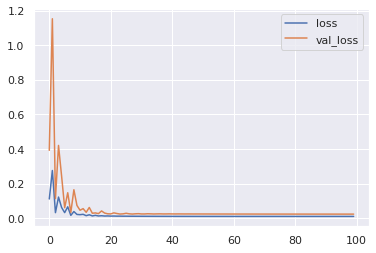

In [161]:
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()

### 2.4.2 Plot the fitted values

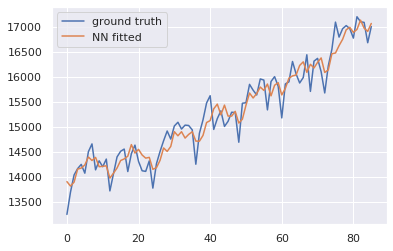

In [162]:
with torch.no_grad():
    plt.plot(scaler.inverse_transform(y_train), label='ground truth')
    plt.plot(scaler.inverse_transform(model(X_train)), label='NN fitted')
    plt.legend();

### 2.4.3 Generate and evaluate a multi-step forecast

Task:
* Using the iterative method produce a 12 step forecast. Save the predictions in a variable called `y_preds_lm`
* Plot the results: predictions versus test
* Calculate the RMSE

In [163]:
def autoregressive_iterative_forecast(model, exog, h):
    '''
    h-step forecast for an autoregressive 
    model using the iterative prediction method.
    
    Conduct h one-step forecasts gradually
    replacing ground truth autoregressive X 
    values with predictions.
    
    Parameters:
    ------
    model: forecast object
        model that has a .predict(h) interface
        
    exog: array-like
        initial vector of lagged values (X)
    
    h: int
        forecast horizon. assumed to be > 0
    
    Returns:
    ------
    numpy.ndarray
        y_predictions
    '''
    y_preds = []
    current_X = exog
    for i in range(h):
        with torch.no_grad():
            y_pred = model(current_X)[0]
        y_preds.append(y_pred)

        current_X = torch.roll(current_X, shifts=-1)
        current_X[-1] = y_pred

    return np.array(y_preds)

In [164]:
def plot_nn_prediction_results(model, X_train, y_train, y_test, y_preds):  
    
    #create series
    with torch.no_grad():
        fitted_values = scaler.inverse_transform(model(X_train))
        
    ground_truth = scaler.inverse_transform(y_train)
    ground_truth_val = scaler.inverse_transform(y_test)

    padding = np.full(len(fitted_values), np.NAN)

    validation = np.concatenate([padding.reshape(-1, 1), ground_truth_val])
    forecast = np.concatenate([padding.reshape(-1, 1), y_preds])

    plt.plot(ground_truth, label='ground truth')
    plt.plot(validation, label='test')
    plt.plot(fitted_values, label='in-sample', linestyle='-.')
    plt.plot(forecast, label='out-of-sample', linestyle='-.')
    plt.legend();

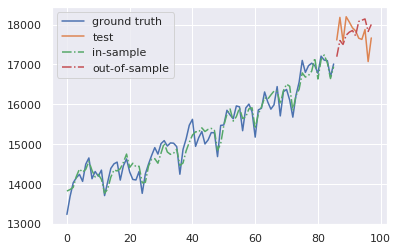

In [165]:
#predict next 12 months and plot
H = 12
y_preds_lm = autoregressive_iterative_forecast(model_lm, X_test[0], h=H)

y_preds_lm = scaler.inverse_transform(y_preds_lm.reshape(-1, 1))

plot_nn_prediction_results(model_lm, X_train, y_train, y_test, y_preds_lm)

In [166]:
rmse(y_preds_lm, scaler.inverse_transform(y_test))[0]

405.85355718937603

## 2.5 Training a non-linear network

Task 
* Introduce a hidden layer(s) to your neural network.  Use a ReLU activation function.

In [122]:
# Base model on torch.nn.Module class
class TwoLayerModel(nn.Module):
    def __init__(self, window_size, n_neurons_l1=32,
                 n_neurons_l2=64):
        # Inherit parent (nn.module) methods using super init
        super(TwoLayerModel, self).__init__()
        #full connected layer
        self.fc1 = nn.Linear(in_features=window_size, 
                             out_features=n_neurons_l1, 
                             bias=True) 
        
        self.fc2 = nn.Linear(in_features=n_neurons_l1, 
                             out_features=n_neurons_l2, 
                             bias=True)
        
        self.out = nn.Linear(in_features=n_neurons_l2, 
                             out_features=1, 
                             bias=True)
        
    def forward(self, x):
        # Pass data through net. 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y_pred = self.out(x)
        return y_pred

In [168]:
torch.manual_seed(45678)

N_EPOCHS = 100

# Create model
model_mlp = TwoLayerModel(WINDOW_SIZE, n_neurons_l1=5, 
                          n_neurons_l2=5)
# Set loss 
criterion = nn.MSELoss()
# Set optimizer
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.1)

history = fit(model_mlp, optimizer, criterion, N_EPOCHS, 
              X_train, y_train, X_test=X_test, y_test=y_test, 
              batch_size=32, verbose=1)

Epoch 10. Train accuracy  0.078. Test accuracy  0.263.
Epoch 20. Train accuracy  0.059. Test accuracy  0.074.
Epoch 30. Train accuracy  0.032. Test accuracy  0.041.
Epoch 40. Train accuracy  0.018. Test accuracy  0.027.
Epoch 50. Train accuracy  0.015. Test accuracy  0.020.
Epoch 60. Train accuracy  0.011. Test accuracy  0.017.
Epoch 70. Train accuracy  0.009. Test accuracy  0.014.
Epoch 80. Train accuracy  0.012. Test accuracy  0.052.
Epoch 90. Train accuracy  0.008. Test accuracy  0.034.
Epoch 100. Train accuracy  0.008. Test accuracy  0.040.
Training time 0.88s


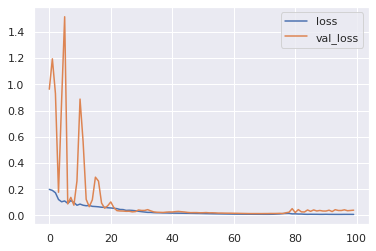

In [169]:
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()

rmse lm: 405.85
rmse mlp: 678.57


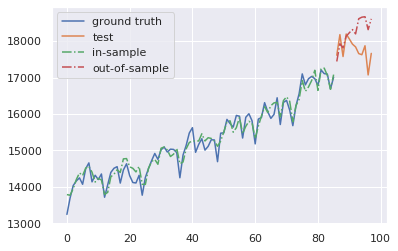

In [170]:
#predict next 12 months and plot
H = 12
y_preds_mlp = autoregressive_iterative_forecast(model_mlp, X_test[0], h=H)
y_preds_mlp = scaler.inverse_transform(y_preds_mlp.reshape(-1, 1))

plot_nn_prediction_results(model_mlp, X_train, y_train, y_test, y_preds_mlp)

rmse_lm = rmse(scaler.inverse_transform(y_test), y_preds_lm)[0]
rmse_mlp = rmse(scaler.inverse_transform(y_test), y_preds_mlp)[0]

print(f'rmse lm: {rmse_lm:.2f}\nrmse mlp: {rmse_mlp:.2f}')

rmse lm: 405.85
rmse mlp: 261.91


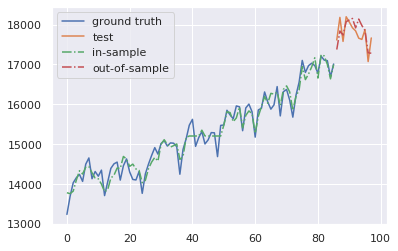

In [185]:
#try changing the network parameters to see the impact on the 
#rmse relative to the linear model

torch.manual_seed(45678)

N_EPOCHS = 100

# Create model
model_mlp = TwoLayerModel(WINDOW_SIZE, n_neurons_l1=5, 
                          n_neurons_l2=32)
# Set loss 
criterion = nn.MSELoss()
# Set optimizer
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.1)

history = fit(model_mlp, optimizer, criterion, N_EPOCHS, 
              X_train, y_train, X_test=X_test, y_test=y_test, 
              batch_size=32, verbose=0)

#predict next 12 months and plot
H = 12
y_preds_mlp = autoregressive_iterative_forecast(model_mlp, X_test[0], h=H)
y_preds_mlp = scaler.inverse_transform(y_preds_mlp.reshape(-1, 1))

plot_nn_prediction_results(model_mlp, X_train, y_train, y_test, y_preds_mlp)

rmse_lm = rmse(scaler.inverse_transform(y_test), y_preds_lm)[0]
rmse_mlp = rmse(scaler.inverse_transform(y_test), y_preds_mlp)[0]

print(f'rmse lm: {rmse_lm:.2f}\nrmse mlp: {rmse_mlp:.2f}')

# Ensemble Learning

In all of the examples above we have been setting a random seed for tensorflow.  This 'suggests' that if we used a different randon number seed we would get a slightly different result. Neural networks are extremely flexible and have many parameters. This leads to one of the key challenges with neural networks - overfitting.  There are multiple ways to deal with overfitting.  In forecasting a common approach is to use an **ensemble** of models.  

In an ensemble we train multiple models. 

## Training an ensemble

We will train an ensemble of neural networks that mimic a linear model.  

In [299]:
def load_pretrained_ensemble_linear(ws, n_models):
    models = []
    for n in range(n_models):
        model_n = LinearModel(ws)
        path = f'./output/ensemble_model{n}.pt'
        model_n.load_state_dict(torch.load(path))
        model_n.eval()
        models.append(model_n)
    return models

In [300]:
#set random seed so that ensemble can be repeated.
torch.manual_seed(1985)

N_MODELS = 20
N_EPOCHS = 100
WINDOW_SIZE = 12

#I've pretrained 50 models you can load them from file if wanted.
LOAD_FROM_FILE = True

if LOAD_FROM_FILE:
    #it will take a few seconds to load.
    models = load_pretrained_ensemble_linear(WINDOW_SIZE,
                                             N_MODELS)
    print('Loaded pre-trained models.')
else:
    models = []
    print('Training ensemble =>', end=' ')
    for n in range(N_MODELS):
        print(f'{n+1}, ', end = ' ')
        #single layer nn
        model_n = LinearModel(WINDOW_SIZE)
        
        # Set loss 
        criterion = nn.MSELoss()
        # Set optimizer
        optimizer = torch.optim.Adam(model_n.parameters(), lr=0.01)

        #fit model silently
        history = fit(model_n, optimizer, criterion, N_EPOCHS, 
                      X_train, y_train, X_test=X_test, y_test=y_test, 
                      batch_size=32, verbose=0)

        path = f'./output/ensemble_model{n}.pt'
        torch.save(model_n.state_dict(), path)
        
        models.append(model_n)
    print('done')

Loaded pre-trained models.


### Predictions in an ensemble

In an ensemble we predict in a loop. In python this is straightfoward as we simply loop through the models we have trained and call `autoregressive_iterative_forecast`. Store the predictions of each forecast in a python `list`  called `e_preds`

In [301]:
#this code will take a few seconds to execute
H = 12
e_preds = []
for model in models:
    y_preds = autoregressive_iterative_forecast(model, X_test[0], h=H)
    e_preds.append(y_preds)
    
e_preds = np.array(e_preds)

Inverse transform the data and calculate the median and 0.025 and 0.975 percentiles of the point forecasts

Remember we can use `scaler.inverse_transform()`

In [302]:
e_preds = np.asarray(e_preds)
e_preds_tran = scaler.inverse_transform(e_preds).T
y_preds_mdn = np.percentile(e_preds_tran.T, 50, axis=0)
y_preds_2_5 = np.percentile(e_preds_tran.T, 2.5, axis=0)
y_preds_97_5 = np.percentile(e_preds_tran.T, 97.5, axis=0)
y_preds_mdn.shape

(12,)

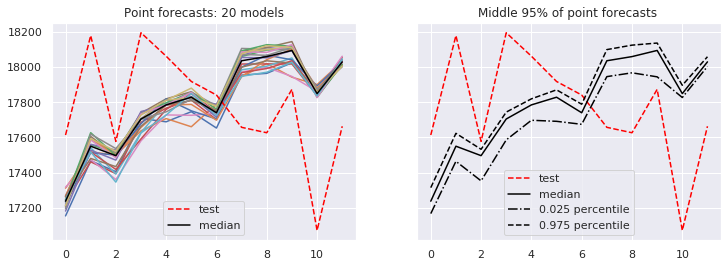

In [303]:
#plot the individual forecasts and the median

fig,ax = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
ax[0].plot(e_preds_tran)
ax[0].plot(scaler.inverse_transform(y_test), label='test', linestyle='--', 
         color='red')
ax[0].plot(y_preds_mdn, label='median', linestyle='-', color='black')
ax[0].legend()
ax[0].set_title(f'Point forecasts: {N_MODELS} models')

ax[1].plot(scaler.inverse_transform(y_test), label='test', linestyle='--', 
         color='red')
ax[1].plot(y_preds_mdn, label='median', linestyle='-', color='black')
ax[1].plot(y_preds_2_5, label='0.025 percentile', linestyle='-.', color='black')
ax[1].plot(y_preds_97_5, label='0.975 percentile', linestyle='--', color='black')
#ax[1].plot(y_preds_lm, label='original lmforecast', linestyle='--', color='green')
ax[1].set_title(f'Middle 95% of point forecasts ')
ax[1].legend();

In [304]:
rmse_lm = rmse(scaler.inverse_transform(y_test), y_preds_lm)[0]
rmse_mdn = rmse(scaler.inverse_transform(y_test), y_preds_mdn)[0]

print(f'rmse lm: {rmse_lm:.2f}\nrmse ensemble: {rmse_mdn:.2f}')

rmse lm: 405.85
rmse ensemble: 612.40


In [247]:
rmse_25 = rmse(scaler.inverse_transform(y_test), y_preds_2_5)[0]
rmse_75 = rmse(scaler.inverse_transform(y_test), y_preds_97_5)[0]
print(f'95% of linear models will have rmse between: {rmse_75:.2f} - {rmse_25:.2f}')

95% of linear models will have rmse between: 582.85 - 639.31


## Exercise: Create an ensemble of non-linear models.

The two layer model appears to be more accurate than the simple linear regression model and its ensemble counterpart.

Task: 

* Create an ensemble of 20 models.
* Use the `get_network_model()` and its parameters to compile your model.
* Optional: save your models to file. (recommended)
* Forecast the next 12 periods.
* Calculate the RMSE of the forecast.


Hints:

* You have **all of the code** you need to complete this task!
* Remember to back transform your forecasts
* Use the median of the ensemble.
* Look carefully at the previous ensemble example.



In [309]:
def load_pretrained_ensemble_twolayer(ws, l1, l2, 
                                    n_models):
    models = []
    for n in range(n_models):
        model_n = TwoLayerModel(ws, l1, l2)
        path = f'./output/mlp_ensemble_model{n}.pt'
        model_n.load_state_dict(torch.load(path))
        model_n.eval()
        models.append(model_n)
    return models

In [310]:
#set random seed so that ensemble can be repeated.
torch.manual_seed(1985)

N_MODELS = 50
N_EPOCHS = 100
WINDOW_SIZE = 12

L1 = 5
L2 = 32

#I've pretrained 50 models you can load them from file if wanted.
LOAD_FROM_FILE = True

if LOAD_FROM_FILE:
    #it will take a few seconds to load.
    models = load_pretrained_ensemble_twolayer(WINDOW_SIZE,
                                               L1, L2,
                                               N_MODELS)
    print('Loaded pretrained models.')
else:
    models = []
    print('Training ensemble =>', end=' ')
    for n in range(N_MODELS):
        print(f'{n+1}, ', end = ' ')
        #two layer nn
        model_n = TwoLayerModel(WINDOW_SIZE, n_neurons_l1=L1,
                                n_neurons_l2=L2)
        
        # Set loss 
        criterion = nn.MSELoss()
        # Set optimizer
        optimizer = torch.optim.Adam(model_n.parameters(), lr=0.1)

        #fit model silently
        history = fit(model_n, optimizer, criterion, N_EPOCHS, 
                      X_train, y_train, X_test=X_test, y_test=y_test, 
                      batch_size=32, verbose=0)

        path = f'./output/mlp_ensemble_model{n}.pt'
        torch.save(model_n.state_dict(), path)
        
        models.append(model_n)
    print('done')

Loaded pretrained models.


In [319]:
import time
#this code will take a few seconds to execute
start_time = time.time()
H = 12
e_preds = []
for model in models[:20]:
    y_preds = autoregressive_iterative_forecast(model, X_test[0], h=H)
    e_preds.append(y_preds)
    
e_preds = np.array(e_preds)
time.time() - start_time

0.11712908744812012

In [312]:
e_preds = np.asarray(e_preds)
e_preds_tran = scaler.inverse_transform(e_preds).T
y_preds_mdn = np.percentile(e_preds_tran.T, 50, axis=0)
y_preds_2_5 = np.percentile(e_preds_tran.T, 2.5, axis=0)
y_preds_97_5 = np.percentile(e_preds_tran.T, 97.5, axis=0)
y_preds_mdn.shape

(12,)

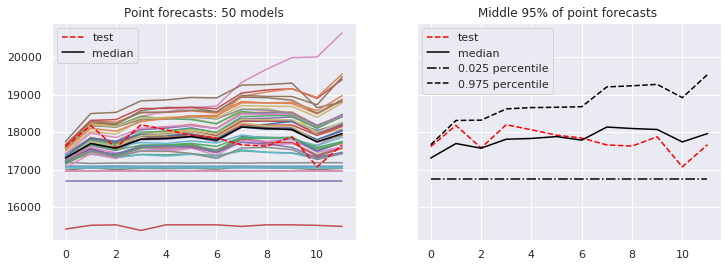

In [313]:
#plot the individual forecasts and the median

fig,ax = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
ax[0].plot(e_preds_tran)
ax[0].plot(scaler.inverse_transform(y_test), label='test', linestyle='--', 
         color='red')
ax[0].plot(y_preds_mdn, label='median', linestyle='-', color='black')
ax[0].legend()
ax[0].set_title(f'Point forecasts: {N_MODELS} models')

ax[1].plot(scaler.inverse_transform(y_test), label='test', linestyle='--', 
         color='red')
ax[1].plot(y_preds_mdn, label='median', linestyle='-', color='black')
ax[1].plot(y_preds_2_5, label='0.025 percentile', linestyle='-.', color='black')
ax[1].plot(y_preds_97_5, label='0.975 percentile', linestyle='--', color='black')
#ax[1].plot(y_preds_lm, label='original lmforecast', linestyle='--', color='green')
ax[1].set_title(f'Middle 95% of point forecasts ')
ax[1].legend();

In [314]:
rmse_lm = rmse(scaler.inverse_transform(y_test), y_preds_lm)[0]
rmse_mdn = rmse(scaler.inverse_transform(y_test.T), y_preds_mdn)[0]

print(f'rmse lm: {rmse_lm:.2f}\nrmse ensemble: {rmse_mdn:.2f}')

rmse lm: 405.85
rmse ensemble: 305.32


## Extra exercises.
* How would you use a ensemble method with a model that predicts a vector?